### Sentiment Analysis for All Tickers

In [18]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob
from datetime import datetime

In [19]:
# List of stock tickers
tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'META', 'NVDA', 'TSLA']

In [20]:
# Load financial news data
news_df = pd.read_csv("../data/raw_analyst_ratings.csv", parse_dates=['date'])
news_df = news_df[["date", "headline", "stock"]]
# news_df['date'] = pd.to_datetime(news_df['date']).dt.date<

# Ensure proper datetime parsing with fallback if needed
# For news_df: parse if not already datetime
if not pd.api.types.is_datetime64_any_dtype(news_df["date"]):
    news_df["date"] = pd.to_datetime(news_df["date"], errors='coerce')

# # For stock_df: same treatment
# if not pd.api.types.is_datetime64_any_dtype(stock_df["date"]):
#     stock_df["date"] = pd.to_datetime(stock_df["date"], errors='coerce')

# Remove time component to keep only the date
news_df["date"] = news_df["date"].dt.date
# stock_df["date"] = stock_df["date"].dt.date

# Drop rows with invalid dates if any
news_df.dropna(subset=["date"], inplace=True)
# stock_df.dropna(subset=["date"], inplace=True)


### Collect Correlations

In [23]:
correlations = []

def get_sentiment(text):
    return TextBlob(str(text)).sentiment.polarity

news_df['sentiment'] = news_df['headline'].apply(get_sentiment)

# Group sentiment by date and stock
daily_sentiment = news_df.groupby(['date', 'stock'])['sentiment'].mean().reset_index()

def safe_correlation(x, y):
    if len(x) < 2 or len(y) < 2:
        return np.nan
    if np.std(x) == 0 or np.std(y) == 0:
        return np.nan
    return np.corrcoef(x, y)[0, 1]

for ticker in tickers:
    print(f"Processing {ticker}...")
    try:
        stock_path = f"../data/{ticker}_historical_data.csv"
        stock_df = pd.read_csv(stock_path)
        stock_df = stock_df[['Date', 'Close']].rename(columns={'Date': 'date'})
        stock_df['date'] = pd.to_datetime(stock_df['date']).dt.date
        stock_df.sort_values('date', inplace=True)
        
        # Compute daily return
        stock_df['return'] = stock_df['Close'].pct_change()
        
        # Filter sentiment for the current ticker
        ticker_sentiment = daily_sentiment[daily_sentiment['stock'] == ticker]
        
        # Merge stock return and sentiment by date
        merged_df = pd.merge(stock_df, ticker_sentiment, on='date', how='inner')
        
        # Compute correlation
        corr = merged_df['return'].corr(merged_df['sentiment'])
        correlations.append({'ticker': ticker, 'correlation': corr})
        
        # Plot
        plt.figure(figsize=(10, 5))
        sns.scatterplot(data=merged_df, x='sentiment', y='return')
        plt.title(f'{ticker}: Sentiment vs Return (r={corr:.2f})')
        plt.xlabel("Average Daily Sentiment")
        plt.ylabel("Daily Stock Return")
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"../output/{ticker}_sentiment_return_corr.png")
        plt.close()
        
    except Exception as e:
        print(f"Error processing {ticker}: {e}")


Processing AAPL...
Processing MSFT...
Processing GOOG...
Processing AMZN...
Processing META...
Processing NVDA...
Processing TSLA...


/home/yta/anaconda3/envs/10ay/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/yta/anaconda3/envs/10ay/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/yta/anaconda3/envs/10ay/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


### Correlation Table and Heatmap


Sentiment vs Return Correlation:
  ticker  correlation
0   AAPL    -1.000000
1   MSFT          NaN
2   GOOG    -0.089449
3   AMZN    -1.000000
4   META          NaN
5   NVDA     0.175714
6   TSLA          NaN


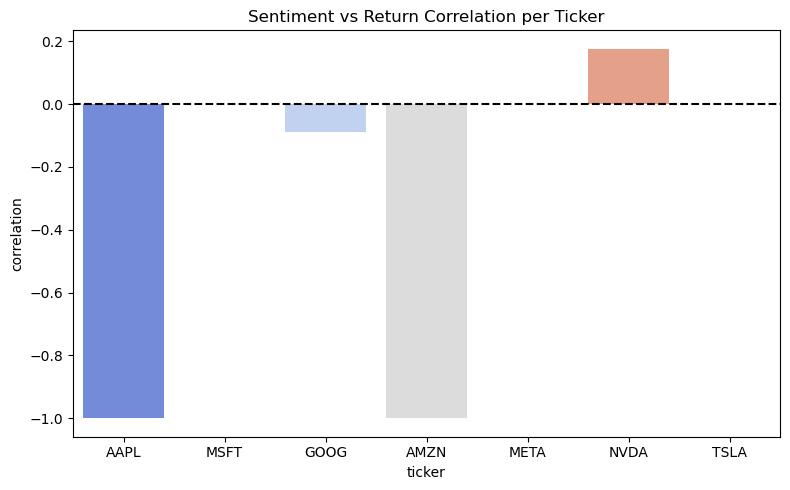

In [ ]:
correlation_df = pd.DataFrame(correlations)
print("\nSentiment vs Return Correlation:")
print(correlation_df)

# Plot summary heatmap
plt.figure(figsize=(8, 5))
sns.barplot(data=correlation_df, x='ticker', y='correlation', hue='ticker', palette='coolwarm', legend=False)
plt.axhline(0, color='black', linestyle='--')
plt.title("Sentiment vs Return Correlation per Ticker")
plt.tight_layout()
plt.savefig("../output/correlation_summary.png")
plt.show()


In [24]:
plt.savefig("../output/all_in_one_correlation.png")

<Figure size 640x480 with 0 Axes>